##Objective

-Visualize the distribution of the data for different user types. This could help in identifying patterns in how different user types watch Netflix.

-Cluster the data and visualize the clusters. This could help in  identifying the different types of Netflix users.

-Identify the factors that are most important for predicting a user's Netflix type. This could help Netflix to improve its recommendations.

-Develop a model that predicts which users are most likely to churn. This could help Netflix to prevent users from churning.

In this notebook, we will analyze the Netflix userbase and draw conclusions based on the dataset. Our analysis will address a variety of intriguing questions related to this dataset.


## Libraries

In [ ]:
pip install scikit-learn


In [ ]:
# Data Loading Code Runs At This Point


import pandas as pd


# 1.0.1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,accuracy_score

# 1.0.2
from pathlib import Path

In [43]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

Let's have a look at the dataset.

# Dataset preprocessing

In [ ]:
# Display from a cell outputs of multiple commands:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Shows output for all possible commands in a cell

In [12]:
df = pd.read_csv('/content/drive/MyDrive/netflix.csv', index_col='User ID')
df.sample(7)

,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
User ID,,,,,,,,,
2035,Premium,11,04-11-2022,10-07-2023,United States,51,Female,Smart TV,1 Month
1871,Basic,10,15-08-2022,06-07-2023,United States,43,Female,Smart TV,1 Month
2446,Premium,11,18-10-2022,12-07-2023,France,46,Male,Tablet,1 Month
582,Basic,12,16-07-2022,28-06-2023,Canada,43,Female,Laptop,1 Month
1653,Standard,13,01-07-2022,06-07-2023,Mexico,32,Male,Smartphone,1 Month
87,Premium,15,28-12-2021,23-06-2023,Brazil,45,Male,Smart TV,1 Month
2402,Premium,12,05-10-2022,11-07-2023,Brazil,47,Female,Smartphone,1 Month


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First of all, Let's pay attention that dataset consists of nine independent variables which are:
 - Subscription Type: ['Basic', 'Premium', 'Standard']
 - Monthly Revenue: total amount of money generated by a user within a single month (solely based on the chosen subscription type)
 - Join Date: when a user signs up (marks the beginning of user subscription period)
 - Last Payment Date: marks the end of user subscription period
 - Country
 - Age
 - Gender ['Male', 'Female']
 - Device ['Smartphone', 'Tablet', 'Smart TV', 'Laptop']
 - Plan Duration ['1 Month']

We can see that names of some columns are too long. Let's shorten and adjust them.

In [14]:
df.rename(
    columns={
        'Subscription Type': 'Sub_type',
        'Monthly Revenue': 'Monthly_revenue',
        'Join Date': 'First_sub_date',
        'Last Payment Date': 'Last_sub_date',
        'Plan Duration': 'Plan_duration',
    },
    inplace=True
)

df.index.rename('ID', inplace=True)

df.sample(7)

,Sub_type,Monthly_revenue,First_sub_date,Last_sub_date,Country,Age,Gender,Device,Plan_duration
ID,,,,,,,,,
738,Standard,14,26-06-2022,01-07-2023,Mexico,44,Female,Smartphone,1 Month
2197,Basic,11,13-08-2022,10-07-2023,Spain,28,Male,Smartphone,1 Month
197,Basic,14,27-09-2022,23-06-2023,Brazil,45,Male,Tablet,1 Month
2377,Basic,14,20-10-2022,12-07-2023,Spain,50,Female,Tablet,1 Month
1936,Premium,13,15-07-2022,10-07-2023,France,36,Male,Laptop,1 Month
1555,Basic,13,31-10-2022,04-07-2023,United States,43,Female,Smartphone,1 Month
570,Basic,10,20-11-2022,30-06-2023,Germany,41,Female,Laptop,1 Month


It looks way better than before. Although we shortened column names, we are still able to recognize each meaning easily.

Now, we must ensure data integrity and reliability. It is vital for accurate analyses and conclusions.

In [15]:
df.isnull().sum()

Sub_type           0
Monthly_revenue    0
First_sub_date     0
Last_sub_date      0
Country            0
Age                0
Gender             0
Device             0
Plan_duration      0
dtype: int64

Well, a perfect dataset with no missing values – absolutely fantastic!

Maybe there are some duplicates in there that we don't want?

In [16]:
if df.duplicated().any():
    print("The same values Found!")
else:
    print("The same values not found.")

The same values not found.


Alright, It looks like our data is quite clean, isn't it?

Let's see the sample to gain a better understanding of the data types.

In [17]:
formatted_data = []
column_name_width = 20
column_value_width = 25

for column_name, column_value in df.loc[1].items():
    column_dtype = df[column_name].dtype
    formatted_data.append(f"{column_name.ljust(column_name_width)}{str(column_value).ljust(column_value_width)}{column_dtype}")

sample_output = "\n".join(formatted_data)
print(sample_output)


Sub_type            Basic                    object
Monthly_revenue     10                       int64
First_sub_date      15-01-2022               object
Last_sub_date       10-06-2023               object
Country             United States            object
Age                 28                       int64
Gender              Male                     object
Device              Smartphone               object
Plan_duration       1 Month                  object


We can see that most of the columns have a type of 'object'. This data type is not desirable when it comes to our analysis.

Firstly, we need to change the date format to make calculations easier.

In [18]:
df['First_sub_date'] = pd.to_datetime(df['First_sub_date'], format='%d-%m-%Y')
df['Last_sub_date'] = pd.to_datetime(df['Last_sub_date'], format='%d-%m-%Y')

df['Sub_period'] = (df['Last_sub_date'] - df['First_sub_date'])
df['Sub_period'] = df['Sub_period'].dt.days

When we're trying to sort users into different groups, it's smarter to use numerical values for common features. This way, we can use these numbers to make decisions and find patterns in the data easily.



In [19]:
# Fit the LabelEncoders for each column
sub_type_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
device_encoder = LabelEncoder()

train_df = df[['Sub_type', 'Age', 'Gender', 'Device', 'Sub_period']].copy()
train_df['Sub_type'] = sub_type_encoder.fit_transform(train_df['Sub_type'])
train_df['Gender'] = gender_encoder.fit_transform(train_df['Gender'])
train_df['Device'] = device_encoder.fit_transform(train_df['Device'])
train_df.sample(7)

,Sub_type,Age,Gender,Device,Sub_period
ID,,,,,
1761,1,37,1,1,240
1460,0,45,1,1,296
71,0,27,1,2,510
17,0,30,0,0,517
2383,2,35,0,3,247
171,1,35,0,3,421
471,1,43,1,3,354


Great! We've successfully encoded the 'Sub_type,' 'Gender,' and 'Device' features. Additionally, we've created a 'train_df' to store the most relevant information.

# Classifying users
Let's classify users using a clustering algorithm -KMeans algorithm.

💡**TIP**💡: Inertia tells how far away the points within a cluster are (sum of squared distances).

array([[202.67180202],
       [346.40521032],
       [189.65074673],
       ...,
       [ 31.44972073],
       [ 27.06649837],
       [ 24.70124154]])

array([[251.29442447, 152.10717589],
       [395.0860238 , 295.73899465],
       [140.97987872, 240.31439165],
       ...,
       [ 80.09124653,  19.41170219],
       [ 74.6787783 ,  26.93037695],
       [ 73.16581709,  26.6115116 ]])

array([[160.39687476, 253.04963926,   9.38855529],
       [304.04382714, 396.84269325, 147.42152661],
       [232.00960333, 139.2236477 , 388.63463013],
       ...,
       [ 11.20529256,  81.84730664, 167.61227801],
       [ 19.30345535,  76.42133216, 173.97521588],
       [ 18.46949263,  74.9202798 , 174.60876809]])

array([[246.02324784, 158.40567316, 389.07221072,   9.11588681],
       [389.80964457, 302.04725211, 532.94859642, 141.05752157],
       [146.25462617, 234.00619691,   5.05438956, 394.9980161 ],
       ...,
       [ 74.8164336 ,  13.16916691, 217.94429808, 173.97561915],
       [ 69.44619486,  21.07690189, 212.17198474, 180.33110582],
       [ 67.89778705,  20.42187859, 210.96297457, 180.97000044]])

array([[258.09284994, 145.9152995 , 396.92964972,  10.56447931,
        200.4871347 ],
       [401.89143044, 289.51276163, 540.81873926, 137.73177921,
        344.22013535],
       [134.17705118, 246.54148197,   6.59755847, 398.32382441,
        191.83584134],
       ...,
       [ 86.89412639,  25.62610919, 225.81778193, 177.30114263,
         29.2716768 ],
       [ 81.43864269,  32.77364505, 220.06028215, 183.6563413 ,
         25.04957787],
       [ 79.96132366,  32.81743786, 218.82849159, 184.2932433 ,
         22.53927514]])

array([[141.08029959, 262.23434641, 179.73460443, 402.0581722 ,
         11.74456533, 220.01651609],
       [284.65703396, 406.03128835, 323.44334747, 545.95609337,
        136.08306831, 363.77719336],
       [251.39778349, 130.03617621, 212.6117762 ,  11.08611916,
        399.97205643, 172.28189617],
       ...,
       [ 30.47092517,  91.03323762,   8.65818311, 230.95782607,
        178.95015238,  48.79888327],
       [ 37.44698495,  85.53293919,   9.91887156, 225.21176243,
        185.29340497,  43.80632663],
       [ 37.64840541,  84.10221855,   4.01652733, 223.96286205,
        185.9452767 ,  41.93150279]])

array([[143.74245111, 263.33017229, 182.12936249, ..., 402.0581722 ,
         70.75337535, 222.72024102],
       [287.32951233, 407.12463311, 325.83287065, ..., 545.95609337,
         74.30444963, 366.49388628],
       [248.72500752, 128.94146095, 210.22159992, ...,  11.08611916,
        461.84248892, 169.56858836],
       ...,
       [ 27.80459477,  92.12625794,  11.00810841, ..., 230.95782607,
        240.84397003,  51.51301124],
       [ 34.8639231 ,  86.60755626,  10.58272293, ..., 225.21176243,
        246.99220885,  46.51837341],
       [ 34.99143253,  85.19830299,   5.48116821, ..., 223.96286205,
        247.87594592,  44.61906395]])

array([[271.76866802, 177.58225847,  55.8715545 , ..., 245.02321788,
        212.01848685,  70.75337535],
       [415.56663328, 321.28291653, 199.30574387, ..., 388.82293341,
        355.7598508 ,  74.30444963],
       [120.5005672 , 214.77157996, 336.76002057, ..., 147.24733975,
        180.29648891, 461.84248892],
       ...,
       [100.56690436,   6.58975076, 115.73866732, ...,  73.82943645,
         40.79303175, 240.84397003],
       [ 94.99464328,   9.53103066, 122.31557009, ...,  68.53155307,
         35.95709976, 246.99220885],
       [ 93.63534486,   3.91540969, 122.71066456, ...,  66.89446593,
         33.97956802, 247.87594592]])

array([[177.73410335, 243.46465705, 142.95280383, ..., 211.81371442,
         63.02671979, 268.19489092],
       [321.43861878, 387.259198  , 286.53231653, ..., 355.5558069 ,
        206.39221203, 411.99212887],
       [214.61622907, 148.80881547, 249.52256782, ..., 180.50069458,
        329.66378608, 124.07486933],
       ...,
       [  6.73224033,  72.26546297,  28.60405411, ...,  40.5888918 ,
        108.64657619,  96.99354585],
       [  9.60884294,  66.96743814,  35.61684662, ...,  35.76664122,
        115.16785174,  91.44438942],
       [  3.81947195,  65.33734515,  35.79346056, ...,  33.77426899,
        115.64462166,  90.06241426]])

array([[268.19489092, 133.8987297 ,  49.78162697, ...,  74.15475262,
        243.68995658, 156.03135294],
       [411.99212887, 277.46834082, 193.1706708 , ...,  70.84272751,
        387.48496411, 299.63856253],
       [124.07486933, 258.58587968, 342.89682652, ..., 465.30399707,
        148.58329294, 236.41636099],
       ...,
       [ 96.99354585,  37.63362   , 121.8735569 , ..., 244.30486797,
         72.49103734,  15.59211769],
       [ 91.44438942,  44.50773843, 128.43784548, ..., 250.45403062,
         67.19213194,  23.09434166],
       [ 90.06241426,  44.76877682, 128.84442092, ..., 251.33464506,
         65.56227744,  22.88284245]])

array([[334.97028826, 136.57967075, 243.68995658, ..., 268.19489092,
        157.38913113,  89.62391654],
       [478.85377744, 280.14356945, 387.48496411, ..., 411.99212887,
        301.01492334, 233.07649291],
       [ 57.38570953, 255.91156536, 148.58329294, ..., 124.07486933,
        235.03890583, 302.97746427],
       ...,
       [163.85826166,  34.9725194 ,  72.49103734, ...,  96.99354585,
         14.20668999,  81.97222955],
       [158.24256508,  41.85158748,  67.19213194, ...,  91.44438942,
         21.92175944,  88.53051194],
       [156.86247992,  42.13069655,  65.56227744, ...,  90.06241426,
         21.48101377,  89.00798153]])

array([[139.25314725, 243.04669913, 214.44180797, ..., 293.80089294,
         97.6699676 , 264.95533276],
       [282.83641324, 386.84718891, 358.18808064, ..., 437.6197555 ,
        241.09269321, 408.74843499],
       [253.21803883, 149.22379953, 177.86876525, ...,  98.46069038,
        294.96262623, 127.31690903],
       ...,
       [ 32.27686465,  71.8537701 ,  43.2190415 , ..., 122.61586524,
         73.97072295,  93.75088698],
       [ 39.25866529,  66.5890189 ,  38.31901152, ..., 116.98104416,
         80.48700777,  88.21224832],
       [ 39.43398903,  64.91788986,  36.38777249, ..., 115.66685712,
         81.04417573,  86.82385994]])

array([[242.98923938, 163.02693574, 264.74081705, ..., 292.84005069,
        144.36315894, 123.635616  ],
       [386.78875305, 306.67654814, 408.53625706, ..., 436.64938103,
        287.94385314, 267.16016735],
       [149.28174092, 229.37688072, 127.53015092, ...,  99.42381651,
        248.11137333, 268.89493272],
       ...,
       [ 71.79537749,   8.64846582,  93.53857808, ..., 121.6453943 ,
         27.20034515,  47.93153669],
       [ 66.52687858,  17.00129959,  88.01024213, ..., 115.98621451,
         34.24098516,  54.62449742],
       [ 64.86071374,  15.93208781,  86.6090553 , ..., 114.70496337,
         34.39941525,  55.05063633]])

array([[265.02922935, 159.61775663,  93.51307098, ..., 218.30683682,
         78.82980357, 123.00453115],
       [408.82184793, 303.23605718,  51.21062173, ..., 362.04263735,
        222.23054199, 266.51629802],
       [127.24325321, 232.81836514, 484.93181078, ..., 174.01213554,
        313.82352827, 269.53960871],
       ...,
       [ 93.82440305,  12.05205677, 263.92712588, ...,  47.07280302,
         92.81330909,  48.57976109],
       [ 88.28331347,  19.8165532 , 270.08892569, ...,  41.98214466,
         99.33416261,  55.24078737],
       [ 86.89788169,  19.36783414, 270.94654044, ...,  40.25599848,
         99.84004448,  55.70527174]])

array([[214.91282996, 165.94295202, 242.49782088, ..., 352.89916969,
        263.81033587, 145.05392995],
       [358.65956378, 309.59305099, 386.30298244, ..., 496.77829071,
        407.36884487, 289.01465683],
       [177.39726648, 226.46015263, 149.7705235 , ...,  39.51115864,
        128.81960179, 247.21110493],
       ...,
       [ 43.69014717,   5.90593944,  71.31073382, ..., 181.7785448 ,
         92.54941012,  26.76516955],
       [ 38.77565406,  14.55295563,  66.07495983, ..., 176.09562777,
         86.29416427,  35.8320426 ],
       [ 36.85687127,  13.18143959,  64.36841291, ..., 174.79036048,
         85.87275561,  33.16144777]])

array([[230.2146276 , 128.36709669, 293.00482287, ...,  79.65451093,
        346.90320956, 479.2402679 ],
       [373.99085701, 271.90414801, 436.82274198, ..., 223.02729529,
        490.76352432, 623.13660972],
       [162.07108356, 264.15139726,  99.25672092, ..., 313.02679509,
         45.42671907,  87.21516138],
       ...,
       [ 59.00743202,  43.19715494, 121.81888322, ...,  92.02159771,
        175.75931499, 308.13549678],
       [ 53.84333112,  49.93923463, 116.18505528, ...,  98.5138287 ,
        170.0438771 , 302.2817136 ],
       [ 52.10633566,  50.32980396, 114.87081918, ...,  99.05642051,
        168.78389577, 301.1477783 ]])

array([[293.00482287, 122.933125  , 182.9686569 , ..., 201.52599787,
        414.90514038, 263.86363345],
       [436.82274198, 266.46067078, 326.70058881, ..., 345.25909856,
        558.79652936, 407.4225089 ],
       [ 99.25672092, 269.59394067, 209.357134  , ..., 190.79784381,
         23.19460704, 128.76558752],
       ...,
       [121.81888322,  48.62705993,  11.84281448, ...,  30.31301132,
        243.79145906,  92.60267244],
       [116.18505528,  55.32533637,  11.49423436, ...,  26.00486411,
        238.01288338,  86.34810381],
       [114.87081918,  55.74137056,   5.79207519, ...,  23.56511001,
        236.80490118,  85.92540747]])

array([[262.93999052, 123.41968775, 218.32825273, ..., 145.41766595,
        143.99032928, 414.90514038],
       [406.49709097, 266.94463441, 362.0659756 , ..., 288.59455514,
        287.95266236, 558.79652936],
       [129.69105246, 269.11038777, 173.98890866, ..., 247.60380455,
        248.27487356,  23.19460704],
       ...,
       [ 91.68007907,  48.14535159,  47.09515437, ...,  27.54620904,
         27.80655513, 243.79145906],
       [ 85.42306222,  54.83994278,  42.01537916, ...,  32.77912137,
         36.80730125, 238.01288338],
       [ 85.00684642,  55.26428817,  40.27512707, ...,  35.05280509,
         34.22240872, 236.80490118]])

array([[144.59818854, 235.23092136, 386.46210932, ..., 264.34873047,
        122.84340935,  81.97533544],
       [287.75908627, 379.14982047, 530.36082906, ..., 408.32450938,
        266.37765597, 225.44254309],
       [248.44606106, 157.05172585,   7.60554342, ..., 128.06717972,
        269.67655826, 310.61309387],
       ...,
       [ 28.39249996,  64.2835218 , 215.3608945 , ...,  93.5099973 ,
         48.70590441,  89.59714242],
       [ 33.60401003,  59.78551567, 209.65116026, ...,  88.74398687,
         55.421316  ,  96.18148833],
       [ 35.89497746,  57.1634701 , 208.36553753, ...,  86.36464151,
         55.81601051,  96.61399129]])

array([[334.65918622, 185.09223359, 243.44450519, ..., 263.14293809,
        144.53218631, 143.55718206],
       [478.50023472, 328.46155758, 387.40958229, ..., 406.70815234,
        287.68979646, 287.52094698],
       [ 57.62195274, 207.72006494, 148.90430655, ..., 129.47032953,
        248.51700849, 248.70847121],
       ...,
       [163.49309815,  15.16641964,  72.62145961, ...,  91.8805458 ,
         28.46991645,  28.235257  ],
       [157.76374916,   8.10094935,  68.19312968, ...,  85.64471191,
         33.67082457,  37.21546194],
       [156.53088854,  11.89315082,  65.45125604, ...,  85.19806554,
         35.97233584,  34.65735004]])

array([[417.36030154, 228.7371604 , 140.19879658, ..., 144.97495625,
        244.33529417, 190.64575072],
       [561.24402186, 372.55707981, 283.35721976, ..., 288.94870291,
        387.84733357, 334.03429305],
       [ 25.53139383, 163.52699191, 252.8361293 , ..., 247.2954672 ,
        148.34964475, 202.14678396],
       ...,
       [246.23660868,  57.58898415,  32.59245737, ...,  26.91181823,
         73.11736158,  20.24060935],
       [240.43711427,  52.6877052 ,  38.00247726, ...,  36.05417749,
         66.77429077,  13.34924218],
       [239.25558862,  50.61451051,  40.05146322, ...,  33.26381299,
         66.55452808,  15.59921793]])

array([[182.08809657, 264.81510419, 143.78549496, ..., 358.04679673,
        187.80842009, 285.98301087],
       [326.0363925 , 408.78729109, 287.74974804, ..., 501.94607439,
        331.16581135, 429.77148085],
       [210.18654466, 127.59271179, 248.48038676, ...,  34.51227152,
        205.03166225, 106.29058242],
       ...,
       [ 12.40522983,  93.96378895,  28.0152399 , ..., 186.95652956,
         17.72333917, 114.77056463],
       [ 16.23365955,  89.17219968,  37.01397733, ..., 181.31004434,
         10.50068581, 109.08110703],
       [  4.80620471,  86.82348767,  34.42989249, ..., 179.95173324,
         13.78730959, 107.84930085]])

array([[121.98772831, 266.39214411, 164.13748981, ..., 178.79631141,
        229.25030598, 185.20882412],
       [265.55865961, 410.35389707, 308.0527611 , ..., 322.13049267,
        373.07022393, 329.17620692],
       [270.49458102, 125.99358195, 228.12129343, ..., 214.06086589,
        163.01376193, 207.08085828],
       ...,
       [ 49.50784476,  95.50360932,   8.56907189, ...,  10.19252858,
         58.10138003,  15.46615229],
       [ 56.31131496,  90.63931699,  19.609525  , ...,   3.49823368,
         53.18720212,  17.96409011],
       [ 56.58903038,  88.37928579,  14.09230897, ...,  10.24065292,
         51.12742517,   7.81036918]])

array([[192.90246602, 247.50755212,  36.89760959, ..., 417.36030154,
        213.50542272,  81.97533544],
       [336.32341155, 391.03685077, 180.0678583 , ..., 561.24402186,
        356.98145516, 225.44254309],
       [199.83939962, 145.14755457, 355.99657104, ...,  25.53139383,
        179.18051946, 310.61309387],
       ...,
       [ 22.27304808,  76.27601707, 134.977993  , ..., 246.23660868,
         42.42530632,  89.59714242],
       [ 15.67658564,  69.9742411 , 141.47944583, ..., 240.43711427,
         36.04561639,  96.18148833],
       [ 17.17814515,  69.67783347, 141.94473782, ..., 239.25558862,
         36.19712969,  96.61399129]])

Text(0.5, 1.0, 'Elbow method')

Text(0.5, 0, 'No. clusters')

Text(0, 0.5, 'Inertia')

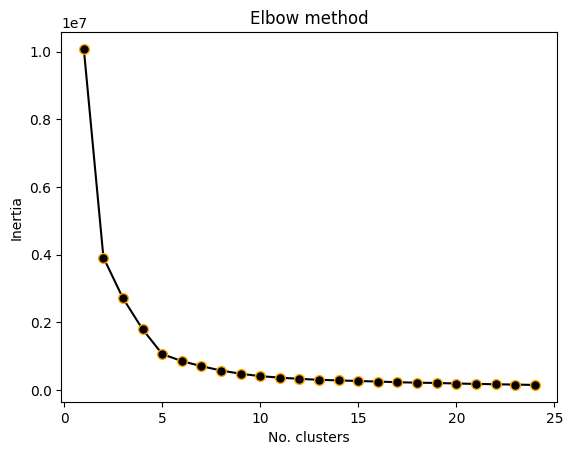

In [20]:

inertias = list()
for i in range(1,25):
    kmeans = KMeans(init = "k-means++", n_clusters = i, n_init = 30)
    kmeans.fit_transform(train_df) # We are interested in all columns, excluding gender and race
    inertias.append(kmeans.inertia_)

plt.plot(range(1,25), inertias, marker='o', color = 'black', mec = 'orange', ms = 7)
plt.title('Elbow method')
plt.xlabel('No. clusters')
plt.ylabel('Inertia')
plt.show()

Great! With this beautiful plot, we need to determine the elbow point. It appears to be 8.

 The elbow point is where the curve starts to flatten.

In [21]:
kmeans = KMeans(init = "k-means++", n_init = 8)
kmeans.fit_transform(train_df.iloc[:, 2:])
kmeans_label = kmeans.labels_
train_df["cluster_group"] = kmeans_label

# Create a copy of the encoded DataFrame
decoded_df = train_df.copy()

# Inverse transform the 'Sub_type', 'Gender', and 'Device' columns
decoded_df['Sub_type'] = sub_type_encoder.inverse_transform(decoded_df['Sub_type'])
decoded_df['Gender'] = gender_encoder.inverse_transform(decoded_df['Gender'])
decoded_df['Device'] = device_encoder.inverse_transform(decoded_df['Device'])

decoded_df.sample(10)

array([[142.65712063, 245.7485757 ,  62.38120166, ..., 272.43099599,
         57.45657721, 212.28569019],
       [286.65968828, 389.75100348, 206.38290435, ..., 416.43305111,
         86.55783191, 356.2878936 ],
       [249.34561003, 146.25395177, 329.62324097, ..., 119.57213537,
        449.45520971, 179.71694131],
       ...,
       [ 28.38974283,  74.76212266, 108.63564429, ..., 101.44178712,
        228.4610253 ,  41.31713864],
       [ 34.38003325,  68.76787098, 114.63145239, ...,  95.44355297,
        234.45911466,  35.31752551],
       [ 35.35192369,  67.75061136, 115.6248382 , ...,  94.43217764,
        235.45639259,  34.29278517]])

,Sub_type,Age,Gender,Device,Sub_period,cluster_group
ID,,,,,,
130,Basic,43,Female,Tablet,167,3
804,Standard,47,Female,Smartphone,375,0
2494,Premium,36,Male,Smart TV,359,0
1010,Basic,36,Female,Tablet,367,0
2476,Basic,28,Male,Tablet,318,4
2260,Premium,31,Male,Tablet,283,7
342,Basic,41,Female,Laptop,321,4
191,Premium,46,Male,Laptop,352,0
1085,Basic,33,Female,Smartphone,366,0


# Let's proceed with a preliminary analysis using these clusters.

How many users do we have in each cluster?

In [22]:
cluster_counts = decoded_df['cluster_group'].value_counts()

print("No. users in each cluster:")
print(cluster_counts)

No. users in each cluster:
0    653
1    479
4    445
5    421
7    397
2     45
3     38
6     22
Name: cluster_group, dtype: int64


Let's visualize it to understand the result better.

<Figure size 800x600 with 0 Axes>

([<matplotlib.patches.Wedge at 0x7f5ebd97c550>,
 [Text(-1.0917632841117748, -0.13436119776733305, ''),
  Text(-0.02841074370330911, -1.0996330431749608, ''),
  Text(0.9973276939446657, -0.46404468630835044, ''),
  Text(0.8738560362995211, 0.6681134842396839, ''),
  Text(-0.12063152272475419, 1.093365463020077, ''),
  Text(-0.6790416849064643, 0.8653914664239474, ''),
  Text(-0.765449018301519, 0.7899922786845711, ''),
  Text(-0.8227818965186402, 0.7300890019450983, '')],
 [Text(-0.5955072458791498, -0.07328792605490893, '26.1%'),
  Text(-0.015496769292714058, -0.5997998417317967, '19.2%'),
  Text(0.5439969239698176, -0.2531152834409184, '17.8%'),
  Text(0.47664874707246596, 0.3644255368580094, '16.8%'),
  Text(-0.06579901239532046, 0.5963811616473147, '15.9%'),
  Text(-0.37038637358534415, 0.4720317089585167, '1.8%'),
  Text(-0.417517646346283, 0.43090487928249327, '1.5%'),
  Text(-0.44879012537380375, 0.3982303646973263, '0.9%')])

Text(0.5, 1.0, 'Distribution of users in Clusters')

(-1.0999995782475758,
 1.0999986956137533,
 -1.0999999425794222,
 1.0999993562383348)

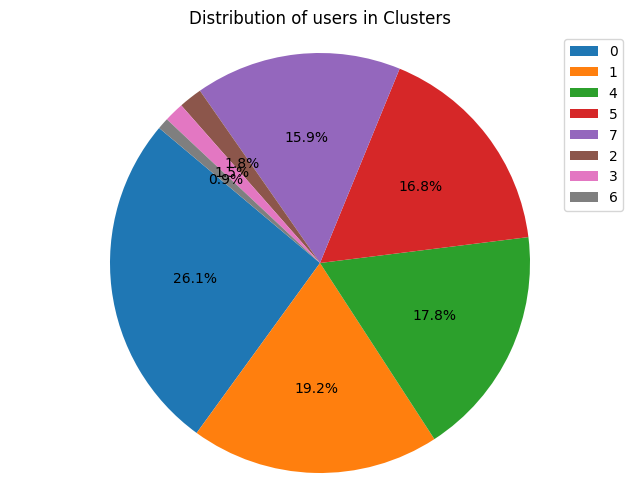

In [23]:
cluster_counts = decoded_df['cluster_group'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=None, autopct='%1.1f%%', startangle=140)

# Add labels for each segment
plt.legend(labels=cluster_counts.index, loc='best')


plt.title('Distribution of users in Clusters')
plt.axis('equal')

plt.show()

 We can see that Cluster 2 has the highest number of users (625), while cluster 3 has the lowest (18).

## Gender distribution
Let's talk about the gender distribution for each cluster.

In [24]:
gender_distribution = decoded_df.groupby(['cluster_group', 'Gender'])['Gender'].count().unstack()

print("Gender Distribution in Clusters:")
print(gender_distribution)

Gender Distribution in Clusters:
Gender         Female  Male
cluster_group              
0                 327   326
1                 229   250
2                  24    21
3                  22    16
4                 222   223
5                 225   196
6                   8    14
7                 200   197


It doesn't appear to be a clear gender domination, as most cluster groups show relatively balanced numbers of females and males.



Text(0.5, 1.0, 'Gender distribution for each Clusters')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Percentage')

Text(0, 5, '50.00%')

Text(0, 5, '47.81%')

Text(0, 5, '53.33%')

Text(0, 5, '57.89%')

Text(0, 5, '50.00%')

Text(0, 5, '53.44%')

Text(0, 5, '36.36%')

Text(0, 5, '50.00%')

Text(0, 5, '50.00%')

Text(0, 5, '52.19%')

Text(0, 5, '46.67%')

Text(0, 5, '42.11%')

Text(0, 5, '50.00%')

Text(0, 5, '46.56%')

Text(0, 5, '63.64%')

Text(0, 5, '50.00%')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

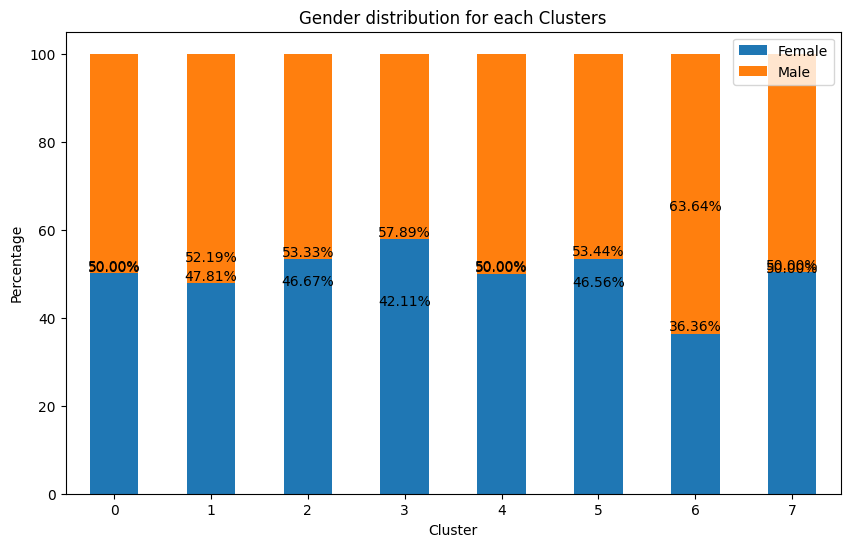

In [25]:
total_by_cluster = gender_distribution.sum(axis=1)
percentage_distribution = gender_distribution.divide(total_by_cluster, axis=0) * 100

ax = percentage_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Gender distribution for each Clusters')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(["Female", "Male"], loc='upper right')

for i in ax.patches:
    percentage = i.get_height()
    if 49.5 < percentage < 51: # Avoid overlapping near 50%
        percentage = 50

    ax.annotate(f'{percentage:.2f}%',
                (i.get_x() + i.get_width() / 2., i.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=0)
plt.show()

## Average age and subscription period
What about average age and subscription period for each cluster?

In [26]:
cluster_stats = decoded_df.groupby('cluster_group').agg({'Age': 'mean', 'Sub_period': 'mean'})

cluster_stats['Age'] = cluster_stats['Age'].astype(int)
cluster_stats['Sub_period'] = cluster_stats['Sub_period'].astype(int)

print("Cluster Statistics (Average Age and Sub_period[days]):")
print(cluster_stats)

Cluster Statistics (Average Age and Sub_period[days]):
               Age  Sub_period
cluster_group                 
0               39         368
1               38         265
2               36         448
3               37         107
4               38         332
5               38         238
6               37         568
7               38         298


<BarContainer object of 2500 artists>

Text(0.5, 1.0, 'Average Sub_period for each Cluster')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Average Sub_period')

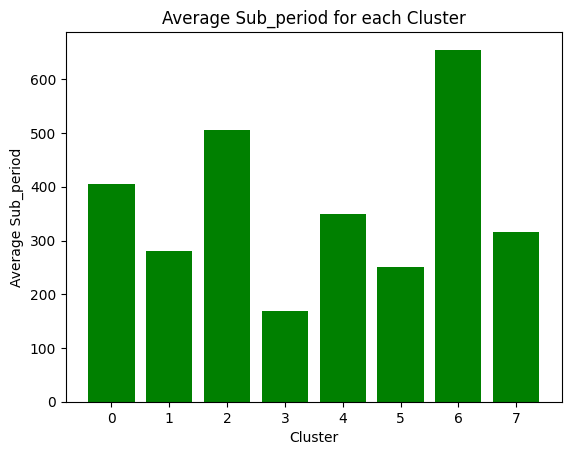

In [27]:
plt.bar(decoded_df['cluster_group'], decoded_df['Sub_period'], color='green')
plt.title('Average Sub_period for each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sub_period')

plt.show()

It looks like Cluster 3 comprises older users with an average age of 39 who exhibit the longest average subscription period of about 580 days, suggesting a highly loyal and committed subscriber base.

In contrast, Cluster 4 represents younger users with an average age of 37 and a relatively short average subscription period of approximately 107 days, implying lower engagement or experimentation with shorter subscriptions.

Cluster 6, despite having the lowest average age of 35, exhibits a substantial average subscription period of approximately 455 days, suggesting early subscription initiation and continued engagement.

## Devices distribution
Let's talk about the devices distribution within each cluster.

In [28]:
devices_distribution = decoded_df.groupby(['cluster_group', 'Device'])['Device'].count().unstack()

print("Devices Distribution in clusters:")
print(devices_distribution)

Devices Distribution in clusters:
Device         Laptop  Smart TV  Smartphone  Tablet
cluster_group                                      
0                 159       166         157     171
1                 136       124         108     111
2                  11         9          11      14
3                  12         8           8      10
4                 107        99         127     112
5                 112       111          92     106
6                   5         3           8       6
7                  94        90         110     103


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Device', ylabel='cluster_group'>

Text(0.5, 1.0, 'Devices distribution in clusters')

Text(0.5, 36.72222222222221, 'Device')

Text(95.72222222222221, 0.5, 'Cluster')

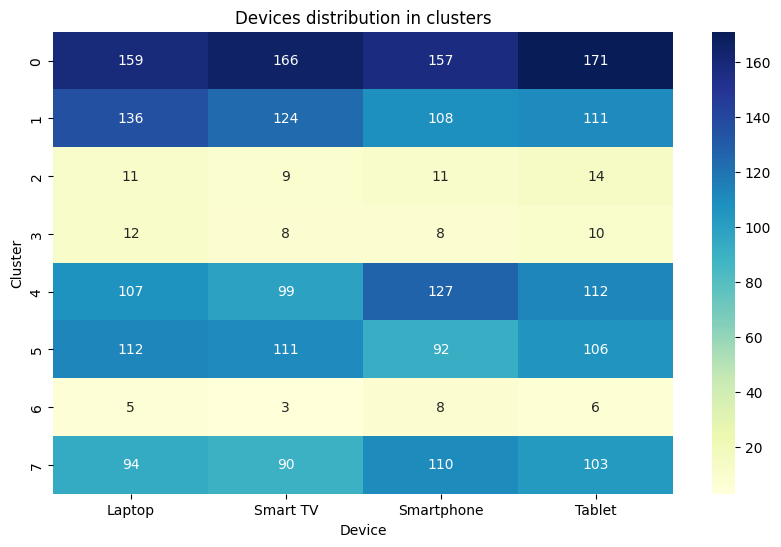

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(devices_distribution, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Devices distribution in clusters')
plt.xlabel('Device')
plt.ylabel('Cluster')
plt.show()

It appears that:
 - Clusters 2, 5, and 7 exhibit a dominant usage of all device types, indicating versatile user preferences across devices.
 - Clusters 0, 1, and 3 show relatively balanced distributions, suggesting diverse device usage patterns among these user groups.
 - Clusters 3 and 4, along with Cluster 6, have notably lower device usage, possibly signifying niche user segments with specialized preferences.

## Potential connections of subscription types
Let's take a look at subscription types and their potential connections with other features such as age, gender, or country.

We should start with making a simple tool(function) to analyze this conveniently.

In [30]:
def check_association(feature_1: str, feature_2: str):
    contingency_table = pd.crosstab(df[feature_1], df[feature_2])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f'{feature_1} vs {feature_2}')
    print("Chi-squared value:", chi2)
    print("P-value:", p)

    if p < 0.05:
        print(f"There is a significant association between {feature_1} and {feature_2}.")
    else:
        print(f"There is no significant association between {feature_1} and {feature_2}.")
    print(64*'*')

In [31]:
check_association('Sub_type', 'Gender')
check_association('Sub_type', 'Age')
check_association('Sub_type', 'Country')

Sub_type vs Gender
Chi-squared value: 0.6282267388216124
P-value: 0.7304362143419851
There is no significant association between Sub_type and Gender.
****************************************************************
Sub_type vs Age
Chi-squared value: 73.1286654741239
P-value: 0.018131908747004287
There is a significant association between Sub_type and Age.
****************************************************************
Sub_type vs Country
Chi-squared value: 1683.8514808245543
P-value: 0.0
There is a significant association between Sub_type and Country.
****************************************************************


Although there isn't a significant association between subscription type and gender, we've found interesting connections with both age and country.

## Geospatial analysis
Let's take a closer look at where our users are from and how their spending is making an impact. This way, we can suggest content they'll love, based on what's trending in their country, for instance.

In [32]:
country_data_revenue = df.groupby('Country')['Monthly_revenue'].sum().reset_index()
country_data_users = df.groupby('Country').size().reset_index(name='User_Count')

# Create a choropleth map showing the total revenue from each country
fig1 = px.choropleth(country_data_revenue, locations='Country', locationmode='country names',
                     color='Monthly_revenue', title='Total Netflix Revenue by Country',
                     hover_name='Country', color_continuous_scale='Plasma')
fig1.show()

# Create a choropleth map showing the number of Netflix users in each country
fig2 = px.choropleth(country_data_users, locations='Country', locationmode='country names',
                     color='User_Count', title='Number of Netflix Users by Country',
                     hover_name='Country', color_continuous_scale='Viridis')
fig2.show()

## RandomForestClassifier

In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [34]:

# Convert the Subscription Type column to numeric
df['Sub_type'] = pd.to_numeric(df['Sub_type'], errors='coerce')
# Convert the Join Date column to datetime
df['First_sub_date'] = pd.to_datetime(df['First_sub_date'],format='%Y-%m-%d')
df['Last_sub_date'] = pd.to_datetime(df['Last_sub_date'],format='%Y-%m-%d')
df['Plan_duration'] = df['Plan_duration'].map({
    '1 Month': 1,
    '3 Month': 3,
    '12 Month':12
})

In [35]:
df['First_sub_date'] = df['First_sub_date'].dt.strftime('%Y-%m-%d')

# Convert the Last Payment Date column to string
df['Last_sub_date'] = df['Last_sub_date'].dt.strftime('%Y-%m-%d')

In [36]:

X_train, X_test, y_train, y_test = train_test_split(df, df['Sub_type'], test_size=0.2)



In [37]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)



In [44]:
rfc.fit(X_train,y_train)


ValueError: ignored

In [39]:
rf_classifier.fit(X_train, y_train)


NameError: ignored

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Sub_type'], test_size=0.2)


In [41]:
dtc = DecisionTreeClassifier()


In [42]:
dtc.fit(X_train, y_train)

ValueError: ignored

# Conclusion
Regarding Netflix userbase, the following factors have been observed:
- Clusters exhibit varying gender distributions, with some clusters having a balanced distribution while others show differences in male and female users.

- Cluster 3 comprises older users (average age of 39) with the longest average subscription period (approximately 580 days), indicating a loyal and committed subscriber base.

- Cluster 4 represents younger users (average age of 37) with a relatively short average subscription period (around 107 days), suggesting lower engagement.

- Cluster 6, despite having the lowest average age (35), has a significant average subscription period (about 455 days), indicating early subscription initiation and sustained engagement.

- Clusters 3 and 4, along with Cluster 6, have lower device usage, potentially representing niche user segments.

- While there isn't a significant association between subscription type and gender, interesting connections exist with age and country.

- American users contribute the highest monthly revenue, suggesting strong popularity and adoption of Netflix in the United States.